In [1]:
# lstm autoencoder recreate sequence
from numpy import array
import keras
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils.vis_utils import plot_model

In [2]:
keras.__version__

'2.8.0'

# Reconstruction LSTM Autoencoder
The simplest LSTM autoencoder is one that learns to reconstruct each input sequence.

For these demonstrations, we will use a dataset of one sample of nine time steps and one feature

In [3]:
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))
sequence

array([[[0.1],
        [0.2],
        [0.3],
        [0.4],
        [0.5],
        [0.6],
        [0.7],
        [0.8],
        [0.9]]])

In [4]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')

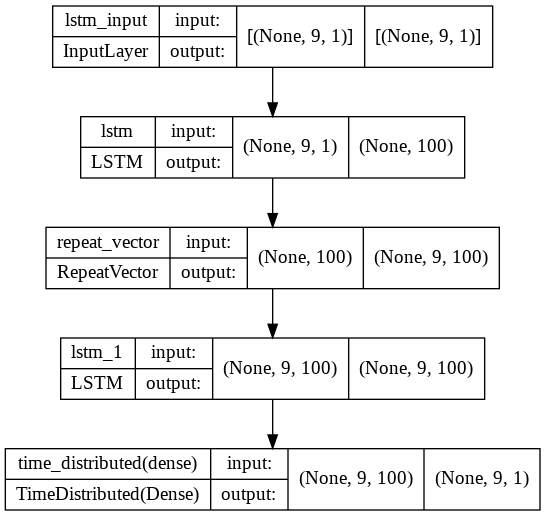

In [8]:
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')

In [6]:
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)

In [7]:
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

[0.10497627 0.20165944 0.2995051  0.39863172 0.4989631  0.5998934
 0.70076674 0.8008493  0.89931226]


# Prediction LSTM Autoencoder

We can modify the reconstruction LSTM Autoencoder to instead predict the next step in the sequence.

In the case of our small contrived problem, we expect the output to be the sequence

In [10]:
# define input sequence
seq_in = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(seq_in)
seq_in = seq_in.reshape((1, n_in, 1))
# prepare output sequence
seq_out = seq_in[:, 1:, :]
n_out = n_in - 1

In [14]:
print(seq_in)
print("-----------------------------")
print(seq_out)

[[[0.1]
  [0.2]
  [0.3]
  [0.4]
  [0.5]
  [0.6]
  [0.7]
  [0.8]
  [0.9]]]
-----------------------------
[[[0.2]
  [0.3]
  [0.4]
  [0.5]
  [0.6]
  [0.7]
  [0.8]
  [0.9]]]


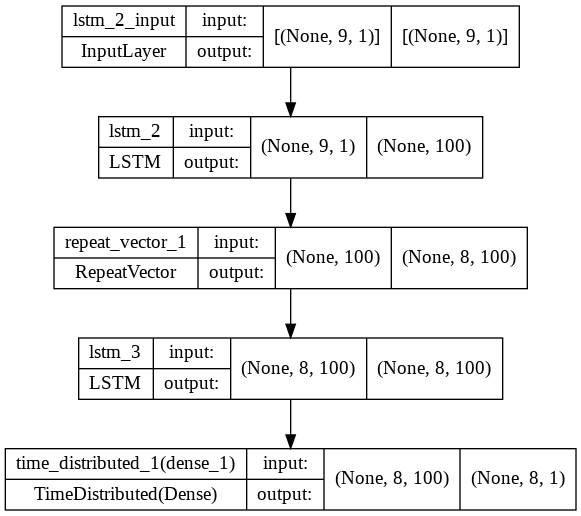

In [15]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='predict_lstm_autoencoder.png')

In [20]:
# fit model
model.fit(seq_in, seq_out, epochs=300, verbose=0)

In [21]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(yhat[0,:,0])

[0.18646075 0.30206496 0.4063219  0.50431985 0.59980613 0.6960176
 0.7960623  0.9032699 ]


#Composite LSTM Autoencoder
Finally, we can create a composite LSTM Autoencoder that has a single encoder and two decoders, one for reconstruction and one for prediction.

We can implement this multi-output model in Keras using the functional API.

In [28]:
from keras.layers import Input
from keras.models import Model

In [24]:
# define encoder
visible = Input(shape=(n_in,1))
encoder = LSTM(100, activation='relu')(visible)

In [25]:
# define reconstruct decoder
decoder1 = RepeatVector(n_in)(encoder)
decoder1 = LSTM(100, activation='relu', return_sequences=True)(decoder1)
decoder1 = TimeDistributed(Dense(1))(decoder1)

In [26]:
# define predict decoder
decoder2 = RepeatVector(n_out)(encoder)
decoder2 = LSTM(100, activation='relu', return_sequences=True)(decoder2)
decoder2 = TimeDistributed(Dense(1))(decoder2)

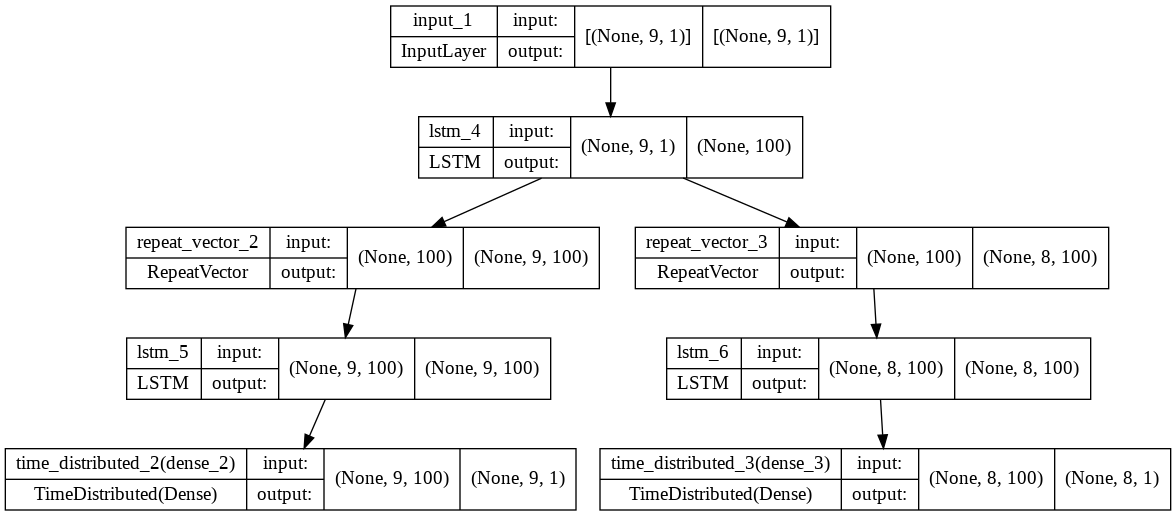

In [30]:
# tie it together
model = Model(inputs=visible, outputs=[decoder1, decoder2])
model.compile(optimizer='adam', loss='mse')
plot_model(model, show_shapes=True, to_file='composite_lstm_autoencoder.png')

In [31]:
# fit model
model.fit(seq_in, [seq_in,seq_out], epochs=300, verbose=0)

In [40]:
# demonstrate prediction
yhat = model.predict(seq_in, verbose=0)
print(*yhat[0])
print("-----------------------------")
print(*yhat[1])

[[0.10850114]
 [0.20441842]
 [0.30136794]
 [0.39917672]
 [0.49775   ]
 [0.5971699 ]
 [0.6976559 ]
 [0.7995421 ]
 [0.9032659 ]]
-----------------------------
[[0.1972833 ]
 [0.30490288]
 [0.39786416]
 [0.49761516]
 [0.5999121 ]
 [0.7016469 ]
 [0.8014256 ]
 [0.8986521 ]]


# Keep Standalone LSTM Encoder
Regardless of the method chosen (reconstruction, prediction, or composite), once the autoencoder has been fit, the decoder can be removed and the encoder can be kept as a standalone model.

In [49]:
model_encoder = Model(inputs=visible, outputs= encoder)

In [50]:
model_encoder.predict(seq_in)

array([[4.61718738e-02, 7.78189152e-02, 0.00000000e+00, 7.41670802e-02,
        0.00000000e+00, 4.00282480e-02, 0.00000000e+00, 0.00000000e+00,
        3.47126834e-02, 0.00000000e+00, 1.62588265e-02, 0.00000000e+00,
        1.09625421e-01, 4.10992106e-05, 0.00000000e+00, 5.14687970e-02,
        7.16137215e-02, 0.00000000e+00, 0.00000000e+00, 7.34376088e-02,
        0.00000000e+00, 0.00000000e+00, 1.14483140e-01, 1.09349519e-01,
        5.53456321e-02, 0.00000000e+00, 0.00000000e+00, 9.17321965e-02,
        0.00000000e+00, 0.00000000e+00, 7.40594864e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.19889523e-02,
        0.00000000e+00, 0.00000000e+00, 1.13097988e-01, 0.00000000e+00,
        1.10553332e-01, 0.00000000e+00, 0.00000000e+00, 9.53963101e-02,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        5.46125397e-02, 0.00000000e+00, 1.16555234e-02, 0.000000

In [ ]:
# Source code https://machinelearningmastery.com/lstm-autoencoders/